In [1]:
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K

from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU

from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf

import imblearn

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

from statsmodels.imputation import mice

imp = mice.MICEData(data)
imp.set_imputer('x1', formula='x2 + np.square(x2) + x3')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.01, 0.005],
    'num_leaves': [10,20,30,40],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'max_bin' : [63,120,255]
    }


grid = GridSearchCV(model4, 
                    gridParams,
                    verbose = 0,
                    cv=5,n_jobs=-1)

from sklearn.cluster import KMeans
scaler = MinMaxScaler()

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import math
import re
import random
import scipy
from scipy import stats

 
    

Using TensorFlow backend.


## 대분류  메타데이터

In [ ]:
genre_gn_all = pd.read_json('.//데이터//genre_gn_all.json', typ = 'series',encoding="utf-8")

In [ ]:
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [ ]:
# 대분류

genre_gn_all[genre_gn_all["gnr_code"].str[-2:] == "00"]

## 곡  메타데이터

In [5]:
song_meta = pd.read_json(".//데이터//song_meta.json",typ = "frame",encoding="utf-8")

In [ ]:
song_meta.head()

In [ ]:
song_meta.info()

### 변수의 의미

#### song_gn_dtl_gnr_basket : 상세 장르 코드
#### issue_date : 곡 발매 일자 (yyyymmdd)
#### album_name : 앨범 명
#### album_id : 앨범 아이디
#### artist_id_basket : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
#### song_name : 곡 명
#### song_gn_gnr_basket : 대분류 장르코드
#### artist_name_basket : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
#### id : 곡 아이디

In [ ]:
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

In [ ]:
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

In [ ]:
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

del song_gnr_map_unnest

In [ ]:
song_gnr_map

In [ ]:
# 대부분은  하나에  하나씩  매핑이지만, 두  개  이상인  경우도  없지는  않다..

song_gnr_map["song_id"].value_counts().value_counts()

# 후에  곡을  일부  추리면서  두  개  이상  매핑  사례가  얼마나  남는지  확인해보자..

In [2]:
rawdata = pd.read_json(".//데이터//train.json",typ="frame",encoding="utf-8")

In [7]:
rawdata_map_unnest = np.dstack(
    (
        np.repeat(rawdata.id.values, list(map(len, rawdata.songs))), 
        np.concatenate(rawdata.songs.values)
    )
)

In [ ]:
rawdata_map_unnest = pd.DataFrame(rawdata_map_unnest[0],columns = ["id","songs"])

In [ ]:
plt.figure(figsize = (20,10))

plt.hist(rawdata_map_unnest["id"].value_counts(),[i*2 for i in range(1,101)])

plt.show()

In [ ]:
temp = rawdata_map_unnest["id"].value_counts().reset_index()

temp.columns = ["id","songs_num"]

In [ ]:
rawdata_id_likecnt = pd.merge(pd.DataFrame(rawdata[["id","like_cnt"]]), temp, on =["id"])

In [ ]:
desc = rawdata_map_unnest["id"].value_counts().describe()

In [ ]:
print("곡  갯수  이상치  이상  like_cnt : ",
    len(rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] > desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"]))
print("곡  갯수  정상범위  like_cnt : ",
     len(rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] <= desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"]))

In [ ]:
print("곡 갯수  이상치  이상  like_cnt의  평균  :",
    np.mean(rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] > desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"]))

print("곡 갯수  정상범위  like_cnt의  평균  :",
np.mean(rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] <= desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"]))

In [ ]:
# 르벤 등분산  검정  결과  등분산이  가정되지  않음(p < .05)

scipy.stats.levene(rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] > desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"],
                rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] <= desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"])

In [ ]:
#이분산  t_test 결과 Like_cnt는 수록된  곡  수가 많은  경우  평균이  유의미하게  다르다는  것을  나타낸다..

scipy.stats.ttest_ind(
    rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] > desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"],
    rawdata_id_likecnt.loc[rawdata_id_likecnt["songs_num"] <= desc["75%"] + 1.5  * (desc["75%"] - desc["25%"]),"like_cnt"],
equal_var = False)

del rawdata_map_unnest

## like_cnt를  하이퍼  파라미터로  활용할  수  있지  않을까??

In [ ]:
rawdata_id_likecnt["like_cnt"].describe()

In [ ]:
plt.figure()
plt.boxplot(rawdata_id_likecnt["like_cnt"])
plt.show()

In [ ]:
plt.figure()
plt.hist(rawdata_id_likecnt_norm["like_cnt"])
plt.show()

In [ ]:
plt.figure()
plt.hist(rawdata_id_likecnt["like_cnt"],[i * 20 for i in range(0,2500)])
plt.show()

In [ ]:
desc = rawdata_id_likecnt["like_cnt"].describe()

In [ ]:
rawdata_id_likecnt_norm = rawdata_id_likecnt.loc[rawdata_id_likecnt["like_cnt"] <= 
                                                 desc["75%"] + 1.5 * (desc["75%"] - desc["25%"]),
                                                 ["like_cnt","songs_num"]]

In [ ]:
### like_cnt와  songs_num은 상관관계가  낮다..

pd.DataFrame({"like_cnt" : ((rawdata_id_likecnt_norm["like_cnt"] - rawdata_id_likecnt_norm["like_cnt"].min()) / 
(rawdata_id_likecnt_norm["like_cnt"].max() - rawdata_id_likecnt_norm["like_cnt"].min())),
              "songs_num" : ((rawdata_id_likecnt_norm["songs_num"] - rawdata_id_likecnt_norm["songs_num"].min()) / 
(rawdata_id_likecnt_norm["songs_num"].max() - rawdata_id_likecnt_norm["songs_num"].min()))}).corr()

del rawdata_id_likecnt_norm
del rawdata_id_likecnt

In [3]:
rawdata_tag_unnest = np.dstack(
    (
        np.repeat(rawdata.id.values, list(map(len, rawdata.tags))), 
        np.concatenate(rawdata.tags.values)
    )
)

In [4]:
rawdata_tag = pd.DataFrame(rawdata_tag_unnest[0],columns=["id","tags"])

del rawdata_tag_unnest

In [122]:
k = rawdata_tag.groupby("id").count()

### tag는  대부분 10개  미만이고, 11개도  5개  경우밖엔  안된다..

In [ ]:
len(pd.unique(rawdata_tag["tags"]))

### tag의  총  갯수는  29160개  이다..

# 데이터 전처리

### 태그  원-핫-인코딩

In [ ]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = rawdata[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs']

# unnest 객체 제거
del plylst_song_map_unnest


# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

del plylst_song_map

In [ ]:
song_del_list = set(song_plylst_cnt.loc[song_plylst_cnt["mapping_plylst_cnt"] == 1,"songs"])

In [ ]:
rawdata_songs_deduction = Series([])
rawdata_songs_deduction = rawdata["songs"].apply(lambda x : list(set(x).difference(song_del_list)))

In [ ]:
#songs 제거 후 

# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = pd.concat([rawdata["id"],rawdata_songs_deduction],axis=1)

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs']

# unnest 객체 제거
del plylst_song_map_unnest

# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt_after = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

del plylst_song_map

In [ ]:
plt.figure()
plt.hist(rawdata["tags"].apply(lambda x : math.floor(len(x) * 0.632)))
plt.show()

In [ ]:
def spliter(x):
    num = len(x)
    r = math.floor(num * 0.632)
    break_num = round(np.log((math.factorial(num)) / (math.factorial(r) * math.factorial(num - r))))
    temp_1 = np.sort(np.random.choice(x,r,replace=False))
    temp_2 = pd.DataFrame([np.sort(np.setdiff1d(x,temp_1).tolist())])
    temp_1 = pd.DataFrame([temp_1.tolist()])
    while True:
        if r == 0:
            temp_2_1 = pd.DataFrame([np.sort(np.setdiff1d(x,temp_1).tolist())])
            temp_1 = pd.DataFrame([[]])
            temp_2 = pd.concat([temp_2,temp_2_1]).drop_duplicates()
            
        if r != 0:
            temp_1_1 = np.sort(np.random.choice(x,r,replace=False))
            temp_2_1 = pd.DataFrame([np.sort(np.setdiff1d(x,temp_1_1).tolist())])
            temp_1_1 = pd.DataFrame([temp_1_1.tolist()])
            temp_1 = pd.concat([temp_1,temp_1_1],axis=0).drop_duplicates()
            temp_2 = pd.concat([temp_2,temp_2_1]).drop_duplicates()
        
        if temp_2.shape[0] >= break_num:
            break
        else:
            pass
    
    return temp_1.values.tolist(),temp_2.values.tolist()

In [ ]:
def spliter(x):
    num = len(x)
    r = math.floor(num * 0.632)
    break_num = round(np.log((math.factorial(num)) / (math.factorial(r) * math.factorial(num - r))))
    temp_1 = pd.DataFrame(np.sort(np.random.choice(x,r,replace=False)))
    temp_2 = pd.DataFrame(x)
    while True:
        if r == 0:
            temp_1 = pd.DataFrame(x)
            
        if r != 0:
            temp_1_1 = pd.DataFrame(np.sort(np.random.choice(x,r,replace=False)))
            temp_2_1 = pd.DataFrame(x)
            temp_1 = pd.concat([temp_1,temp_1_1],axis=1)
            temp_2 = pd.concat([temp_2,temp_2_1],axis=1)
        
        if temp_2.shape[0] >= break_num:
            break
        else:
            pass
    
    return temp_1.T.values.tolist(),temp_2.T.values.tolist()

In [ ]:
rawdata_tag_split = pd.DataFrame([])

start_time = time.time()

temp = rawdata.copy()
temp["songs"] = rawdata_songs_deduction

for i in range(0,len(temp)):

    k1,k2 = spliter(temp.loc[i,"tags"])
    temp_2 = pd.DataFrame([temp.iloc[i,:] for j in range(0,len(k2))])
    temp_2["tags_input"] = k1
    temp_2["tags_output"] = k2
    rawdata_tag_split = pd.concat([rawdata_tag_split,temp_2],axis=0)
    
    
    if i % 1000 == 0:
        print(time.time() - start_time)
        print((i / len(rawdata)) * 100, "percent complete")
        start_time = time.time()

del temp, temp_2

In [95]:
#songs 제거 후 

# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = pd.concat([rawdata_tag_split["id"],rawdata_tag_split["songs"]],axis=1)

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs']

# unnest 객체 제거
del plylst_song_map_unnest

# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt_after = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

del plylst_song_map

In [5]:
rawdata_tag_split.to_csv("rawdata_tag_split_deduction_not_unique_tag.csv",index=False,encoding="utf-8")

NameError: name 'rawdata_tag_split' is not defined

In [64]:
rawdata_tag_split = pd.read_csv("rawdata_tag_split_deduction_not_unique_tag.csv",encoding="utf-8")

rawdata_tag_split["tags_input"] = rawdata_tag_split["tags_input"].apply(lambda x : ast.literal_eval(x))
rawdata_tag_split["tags_output"] = rawdata_tag_split["tags_output"].apply(lambda x : ast.literal_eval(x))
rawdata_tag_split["tags"] = rawdata_tag_split["tags"].apply(lambda x : ast.literal_eval(x))
rawdata_tag_split["songs"] = rawdata_tag_split["songs"].apply(lambda x : ast.literal_eval(x))

In [72]:
tags_input = rawdata_tag_split["tags_input"].copy()
song_input = rawdata_tag_split["songs"].copy()

In [73]:
# inverse를 위해 mlb 절대 삭제하지 말것!

mlb = MultiLabelBinarizer()
mlb = mlb.fit(rawdata_tag_split["tags_output"])
mlb.sparse_output = True

In [74]:
tags_output = mlb.transform(rawdata_tag_split["tags_output"])

In [6]:
### ALL-INPUt 전용

tags_output = rawdata_tag_split["tags_output"].copy()

### 토큰화

In [7]:
def zero_to_inf(seq,length):
    n = 0
    while True:
        temp = seq[n]
        n = n+1
        yield(temp)

In [75]:
play_title = rawdata_tag_split["plylst_title"]

In [76]:
rawdata["plylst_title"].to_csv("plylst_title.txt",index=False)

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [7]:
templates= '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'


In [8]:
train_input_file = "./plylst_title.txt"
pad_id=0  #<pad> token을 0으로 설정
vocab_size = 20000 # vocab 사이즈
prefix = 'plylst_title' # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='unigram' # Choose from unigram (default), bpe, char, or word


In [11]:
cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)

In [12]:
spm.SentencePieceTrainer.Train(cmd)

True

In [77]:
title_encoder = spm.SentencePieceProcessor()
title_encoder.Load("plylst_title.model")

True

In [78]:
title_encoder.SetEncodeExtraOptions('bos:eos')

True

In [85]:
play_title_input = play_title.apply(lambda x : title_encoder.EncodeAsIds(x))
play_title_input = DataFrame(play_title_input.tolist()).fillna(0).to_numpy(dtype="int") 

In [80]:
z_t_i = zero_to_inf([i for i in range(0,len(song_input))],len(song_input))
k = tags_input.apply(lambda x : x  + song_input[next(z_t_i)])

In [ ]:
z_t_i = zero_to_inf([i for i in range(0,len(song_input))],len(song_input))
k = k.apply(lambda x : x  + play_title_input[next(z_t_i)])

In [88]:
rawdata_tag_unnest = np.dstack(
    (
        np.repeat(rawdata_tag_split.id.values, list(map(len, rawdata_tag_split.tags))), 
        np.concatenate(rawdata_tag_split.tags)
    )
)

In [89]:
rawdata_tag = pd.DataFrame(rawdata_tag_unnest[0],columns=["id","tags"])

del rawdata_tag_unnest

In [90]:
dictionary = pd.DataFrame(pd.unique(rawdata_tag["tags"]))

dictionary_tags = pd.concat([Series([0]),dictionary]).reset_index(drop=True)

del rawdata_tag

In [91]:
word2idx = {w : i for i, w in enumerate(dictionary_tags[0])}

In [92]:
tags_input = list(map(lambda x : list(map(lambda y : word2idx[y],x)),tags_input))

In [93]:
tags_input = DataFrame(tags_input).fillna(0).to_numpy(dtype="int")

In [99]:
dictionary_songs = pd.DataFrame(pd.unique(song_plylst_cnt_after["songs"]))

#dictionary_songs = pd.concat([Series([0]),dictionary]).reset_index(drop=True)

In [100]:
word2idx = {w : i for i, w in enumerate(dictionary_songs[0])}

In [101]:
song_input = list(map(lambda x : list(map(lambda y : word2idx[y],x)),rawdata_tag_split["songs"]))

In [102]:
song_input = DataFrame(song_input).fillna(0).to_numpy(dtype="int")

In [18]:
### 모든 인풋을 하나로 묶어서 처리(all_input)
#### Input용



play_title_input = play_title.apply(lambda x : title_encoder.EncodeAsPieces(x))
#play_title_input = DataFrame(play_title_input.tolist()).fillna(0).to_numpy(dtype="int") 

In [19]:
z_t_i = zero_to_inf([i for i in range(0,len(song_input))],len(song_input))
k = play_title_input.apply(lambda x : x  + song_input[next(z_t_i)])

In [20]:
z_t_i = zero_to_inf([i for i in range(0,len(tags_input))],len(tags_input))
inputs = k.apply(lambda x : x  + tags_input[next(z_t_i)])

z_t_i = zero_to_inf([i for i in range(0,len(tags_output))],len(tags_output))
outputs = k.apply(lambda x : x  + tags_output[next(z_t_i)])

In [21]:
z_t_i = zero_to_inf([i for i in range(0,len(tags_output))],len(tags_output))

all_for_dict = inputs.apply(lambda x : x  + outputs[next(z_t_i)])

In [22]:
rawdata_tag_unnest = np.dstack(
    (
        np.repeat(rawdata_tag_split.id.values, list(map(len, all_for_dict))), 
        np.concatenate(all_for_dict)
    )
)

In [23]:
rawdata_tag = pd.DataFrame(rawdata_tag_unnest[0],columns=["id","tags"])

del rawdata_tag_unnest

In [24]:
dictionary = pd.DataFrame(pd.unique(rawdata_tag["tags"]))

dictionary_all = pd.concat([Series(["0"]),dictionary]).reset_index(drop=True)

del rawdata_tag

In [25]:
word2idx = {w : i for i, w in enumerate(dictionary_all[0])}

In [26]:
all_input = list(map(lambda x : list(map(lambda y : word2idx[str(y)],x)),inputs))
all_output = list(map(lambda x : list(map(lambda y : word2idx[str(y)],x)),outputs))
all_for_dict = list(map(lambda x : list(map(lambda y : word2idx[str(y)],x)),all_for_dict))

In [10]:
### 임베딩용  모든 인풋을 하나로 묶어서 처리(all_input)

play_title_input = play_title.apply(lambda x : title_encoder.EncodeAsPieces(x))
#play_title_input = DataFrame(play_title_input.tolist()).fillna(0).to_numpy(dtype="int") 

In [19]:
z_t_i = zero_to_inf([i for i in range(0,len(song_input))],len(song_input))
k = play_title_input.apply(lambda x : x  + song_input[next(z_t_i)])

z_t_i = zero_to_inf([i for i in range(0,len(tags_input))],len(tags_input))
inputs = k.apply(lambda x : x  + tags_input[next(z_t_i)])

z_t_i = zero_to_inf([i for i in range(0,len(tags_output))],len(tags_output))
outputs = k.apply(lambda x : x  + tags_output[next(z_t_i)])

z_t_i = zero_to_inf([i for i in range(0,len(tags_output))],len(tags_output))

all_for_dict = inputs.apply(lambda x : x  + outputs[next(z_t_i)])

rawdata_tag_unnest = np.dstack(
    (
        np.repeat(rawdata_tag_split.id.values, list(map(len, all_for_dict))), 
        np.concatenate(all_for_dict)
    )
)

rawdata_tag = pd.DataFrame(rawdata_tag_unnest[0],columns=["id","tags"])

del rawdata_tag_unnest

dictionary = pd.DataFrame(pd.unique(rawdata_tag["tags"]))

dictionary_all = pd.concat([Series(["0"]),dictionary]).reset_index(drop=True)

del rawdata_tag

word2idx = {w : i for i, w in enumerate(dictionary_all[0])}

all_input = list(map(lambda x : list(map(lambda y : word2idx[str(y)],x)),inputs))
all_for_dict = list(map(lambda x : list(map(lambda y : word2idx[str(y)],x)),all_for_dict))

## 기타 전처리

In [ ]:
def label_unique(x):
    total = x.shape[0]
    num = 0
    temp = np.where(x.toarray()[0] == 1)[0]
    for i in range(0,len(temp)):
        num = num + np.log(temp[i] + 0.00001)
    
    return num

In [ ]:
unique_list = [label_unique(i) for i in tag_one_hot]

In [ ]:
rawdata["unique_list"] = unique_list

In [ ]:
rawdata["unique_list"].astype("str")

### train - test 분할

In [104]:
concat_for_split = DataFrame([Series(play_title_input.tolist(),name="plylst_title"),
           Series(tags_input.tolist(),name="tags"),
           Series(song_input.tolist(),name="songs")]).T

In [105]:
X_train,X_test,y_train,y_test = train_test_split(concat_for_split, tags_output,test_size=0.3)

In [106]:
mlb_2_train = MultiLabelBinarizer()
mlb_2_train = mlb_2_train.fit(X_train["tags"])
mlb_2_train.sparse_output = True

mlb_2_test = MultiLabelBinarizer()
mlb_2_test = mlb_2_test.fit(X_test["tags"])
mlb_2_test.sparse_output = True

In [107]:
X_train_tags = mlb_2_train.transform(X_train["tags"])
X_test_tags = mlb_2_test.transform(X_test["tags"])

In [108]:
X_train_title = np.array(X_train["plylst_title"].tolist())
X_train_songs = np.array(X_train["songs"].tolist())
X_train_tags = np.array(X_train["tags"].tolist())

del X_train

In [109]:
X_test_title = np.array(X_test["plylst_title"].tolist())
X_test_songs = np.array(X_test["songs"].tolist())
X_test_tags = np.array(X_test["tags"].tolist())

del X_test, concat_for_split

In [110]:
with open('./plylst_title.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [35]:
### All_input 전용

X_train,X_test,y_train,y_test = train_test_split(all_input, all_output ,test_size=0.3)

In [111]:
del rawdata_tag_split, inputs, outputs

In [75]:
mlb_2 = MultiLabelBinarizer()
mlb_2 = mlb_2.fit(all_for_dict)
mlb_2.sparse_output = True

In [38]:
X_train = mlb_2.transform(X_train)

X_test = mlb_2.transform(X_test)

In [39]:
y_train = mlb_2.transform(y_train)

y_test = mlb_2.transform(y_test)

In [20]:
### All_input(임베딩) 전용

all_input = DataFrame(all_input).fillna(0).to_numpy(dtype="int")

In [21]:
X_train,X_test,y_train,y_test = train_test_split(all_input, tags_output ,test_size=0.3)

In [22]:
mlb_2 = MultiLabelBinarizer()
mlb_2 = mlb_2.fit(tags_output)
mlb_2.sparse_output = True

In [23]:
y_train = mlb_2.transform(y_train)

y_test = mlb_2.transform(y_test)

In [24]:
gc.collect()

0

## 모델  구성

In [115]:
inputs_1_shape = X_train_title.shape[1]
inputs_2_shape = X_train_songs.shape[1]
inputs_3_shape = X_train_tags.shape[1]

song_embedding_shape = len(dictionary_songs)
tag_embedding_shape = len(dictionary)

output_shape = tags_output.shape[1]
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(word2idx),128)

embed_i = embed(inputs_1)

#Bi-GRU 인코더 - 디코더 네트워크
Encoder1 = layers.GRU(128,input_shape=(None,128),name="Encoder1")
Encoder2 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder2")
initial_1 = Encoder1(embed_i)
initial_1 = layers.BatchNormalization(axis = 1)(initial_1)

initial_2 = Encoder2(embed_i)
initial_2 = layers.BatchNormalization(axis = 1)(initial_2)

context_vector = layers.Concatenate(axis=-1,name = "attention_matrix")([initial_1,initial_2])

inputs_2 = layers.Input(shape = [inputs_2_shape],name = "songs_input")

#곡에 대한 임베딩  레이어를 설정한다.

embed_2 = layers.Embedding(input_dim = song_embedding_shape + 1 , output_dim = 128)

embed_song = embed_2(inputs_2)

#임베딩 조회를 마치고 나온 임베딩 벡터들의 관계를 학습한다.


Encoder3 = layers.GRU(128,input_shape=(None,128),name="Encoder3")
Encoder4 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder4")

initial_3 = Encoder3(embed_song)
initial_3 = layers.BatchNormalization(axis = 1)(initial_3)

initial_4 = Encoder4(embed_song)
initial_4 = layers.BatchNormalization(axis = 1)(initial_4)

song_dense = layers.Concatenate(axis = -1,name="song_initial_state_concat")([initial_3,initial_4])

inputs_3 = layers.Input(shape = [inputs_3_shape],name = "tags_input")

# 태그에 대한 임베딩 레이어를 설정한다.

embed_3 = layers.Embedding(tag_embedding_shape+1,128)

embed_tag = embed_3(inputs_3)

Encoder5 = layers.GRU(128,input_shape=(None,128),name="Encoder5")
Encoder6 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder6")

initial_5 = Encoder5(embed_tag)
initial_5 = layers.BatchNormalization(axis = 1)(initial_5)

initial_6 = Encoder6(embed_tag)
initial_6 = layers.BatchNormalization(axis = 1)(initial_6)

tag_dense = layers.Concatenate(axis = -1,name="tag_initial_state_concat")([initial_5,initial_6])



# 두 벡터를  concat 하는  방안과,, add 하는  방안  두개를  모두  검토하자..
## concat : 두  Input Vector의  가중치가  분리된다..
## add : 두  Input Vector가  동일한  가중치를  공유한다..

concat_vector = layers.Concatenate(axis = -1, name = "concate_three_vector")([context_vector,
                                                                              song_dense,
                                                                                tag_dense
                                                                             ])

predicts = layers.Dense(output_shape,activation="relu")(concat_vector)

In [116]:
#다중 라벨 분류를 위해선 각 정답 노드들의 활성화 함수를 sigmoid로 잡는다. 


tag_identifier_1 = Model(inputs = [inputs_1,
                         inputs_2,
                         inputs_3,
                        ], 
               outputs = [predicts])
tag_identifier_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 42)           0                                            
__________________________________________________________________________________________________
songs_input (InputLayer)        (None, 200)          0                                            
__________________________________________________________________________________________________
tags_input (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 42, 128)      2560000     Feed_Sentence[0][0]              
__________________________________________________________________________________________________
embedding_

In [124]:
## 정답 벡터가 26000차원의 Sparse matrix이므로, 손실함수는 sparse_categorical_crossentropy를 사용한다.

tag_identifier_1.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

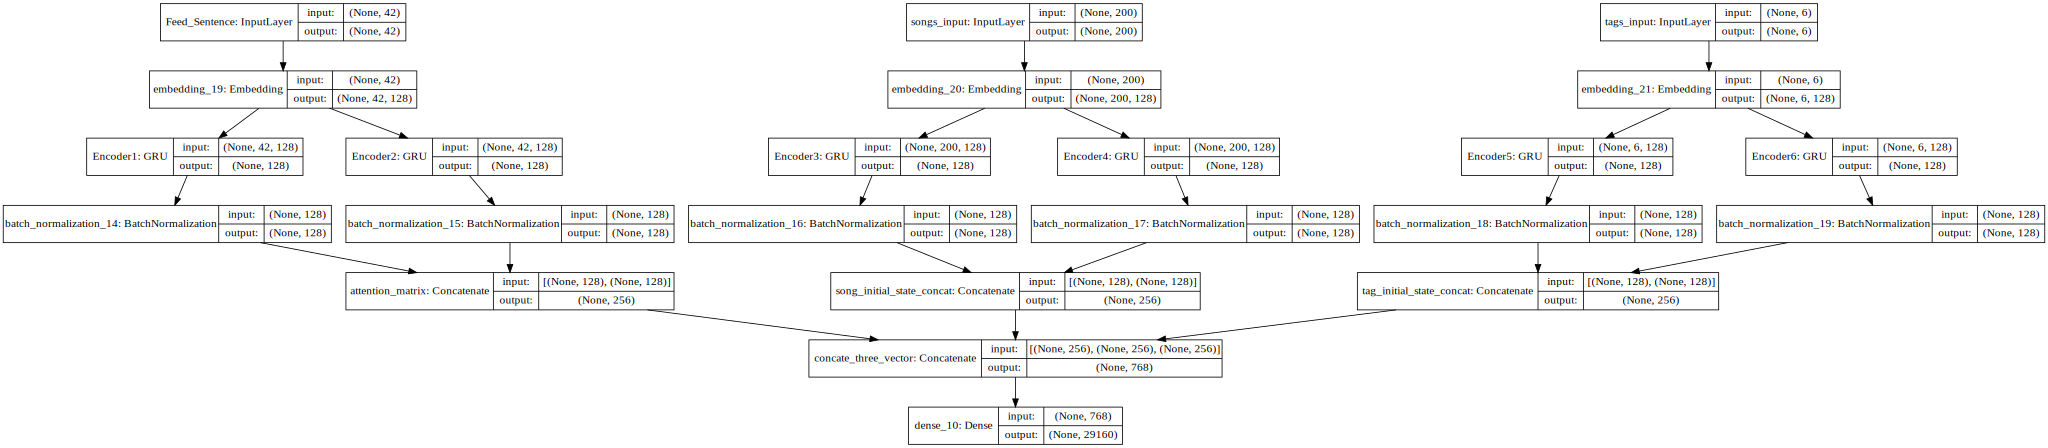

In [125]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(tag_identifier_1,show_shapes=True).create(prog="dot",format="svg"))

In [135]:
tag_identifier_1 = load_model("model_3.h5")

In [136]:
for i in range(2,20):
    tag_identifier_1.fit([X_train_title,X_train_songs,X_train_tags]
               ,y_train,
               epochs=1,
               batch_size = 64,
               validation_data = 
               ([X_test_title,X_test_songs,X_test_tags],
                y_test))
    tag_identifier_1.save("model_"+str(i)+".h5")

Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 8801s 62ms/step - loss: 31.9267 - acc: 0.3148 - val_loss: 47.2250 - val_acc: 0.0877
Train on 142030 samples, validate on 60870 samples
Epoch 1/1
 34688/142030 [======>.......................] - ETA: 1:51:37 - loss: 31.2511 - acc: 0.3201

KeyboardInterrupt: 

In [45]:
inputs_1_shape = X_train.shape[1]

output_shape = y_train.shape[1]


inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

encoder_dense_layer = layers.Dense(1000)

encoder_dense_1 = encoder_dense_layer(inputs_1)

encoder_dense_1 = layers.BatchNormalization(axis = 1)(encoder_dense_1)

reshape_for_add = layers.Dense(1000,kernel_initializer = "ones",name = "reshape_for_add_1",trainable=False)(inputs_1)

encoder_dense_1 = layers.Add(name = "add_for_ResNet")([encoder_dense_1,reshape_for_add])

encoder_dense_1 = layers.Activation(activation="relu")(encoder_dense_1)

embed_dense_layer = layers.Dense(100)

embed_dense = embed_dense_layer(encoder_dense_1)

embed_dense = layers.Activation(activation="relu")(embed_dense)

decoder_dense_1 = layers.DenseTied(1000,tied_to = embed_dense_layer.kernel,use_bias=False)(embed_dense)

decoder_dense_1 = layers.BatchNormalization(axis = 1)(decoder_dense_1)

reshape_for_add_4 = layers.Dense(1000,kernel_initializer = "ones",name = "reshape_for_add_4",trainable=False)(embed_dense)

decoder_dense_1 = layers.Add(name = "add_for_ResNet_4")([decoder_dense_1,reshape_for_add_4])

output = layers.DenseTied(output_shape,tied_to = encoder_dense_layer.kernel,use_bias = False)(decoder_dense_1)

output = layers.BatchNormalization(axis = 1)(output)

output = layers.Activation(activation="relu")(output)

#output = layers.Activation(activation = "relu")(output)

In [46]:
tag_identifier = Model(inputs = [inputs_1], outputs = [output])

tag_identifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 362328)       0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 1000)         362329000   Feed_Sentence[0][0]              
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 1000)         4000        dense_22[0][0]                   
__________________________________________________________________________________________________
reshape_for_add_1 (Dense)       (None, 1000)         362329000   Feed_Sentence[0][0]              
__________________________________________________________________________________________________
add_for_Re

In [47]:
## 정답 벡터가 26000차원의 Sparse matrix이므로, 손실함수는 sparse_categorical_crossentropy를 사용한다.

tag_identifier.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [33]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 4)

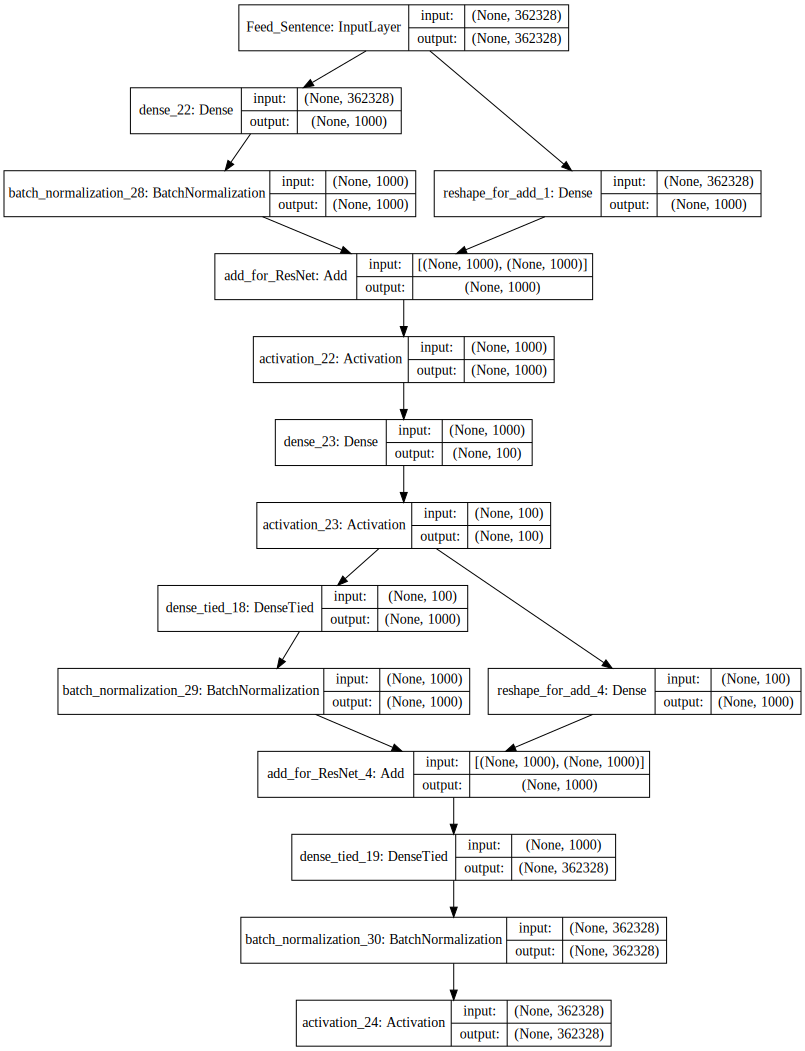

In [49]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(tag_identifier,show_shapes=True).create(prog="dot",format="svg"))

In [35]:
tag_identifier.fit(X_train
           ,y_train,
           epochs=20,
           batch_size = 64,
           validation_data = 
           (X_test,
            y_test),
           callbacks = [early_stopping])

Train on 142030 samples, validate on 60870 samples
Epoch 1/20
142030/142030 [==============================] - 4113s 29ms/step - loss: 708.5158 - acc: 0.0065 - val_loss: 709.2599 - val_acc: 1.9714e-04
Epoch 2/20
142030/142030 [==============================] - 4103s 29ms/step - loss: 708.5145 - acc: 0.0023 - val_loss: 709.2599 - val_acc: 0.0014
Epoch 3/20
142030/142030 [==============================] - 4103s 29ms/step - loss: 708.5140 - acc: 0.0029 - val_loss: 709.2567 - val_acc: 0.0019
Epoch 4/20
142030/142030 [==============================] - 4109s 29ms/step - loss: 708.5223 - acc: 0.0079 - val_loss: 709.2839 - val_acc: 0.0027
Epoch 5/20
142030/142030 [==============================] - 4111s 29ms/step - loss: 708.5243 - acc: 0.0065 - val_loss: 709.2987 - val_acc: 0.0023
Epoch 6/20
142030/142030 [==============================] - 4108s 29ms/step - loss: 708.5259 - acc: 0.0033 - val_loss: 709.2487 - val_acc: 0.0031
Epoch 7/20
142030/142030 [==============================] - 4111s 29m

In [66]:
inputs_1_shape = X_train.shape[1]

output_shape = y_train.shape[1]


inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

encoder_dense_layer = layers.Dense(1000)

encoder_dense = encoder_dense_layer(inputs_1)

encoder_dense = layers.BatchNormalization(axis = 1)(encoder_dense)

reshape_for_add = layers.Dense(1000,kernel_initializer = "ones",name = "reshape_for_add",trainable=False)(inputs_1)

encoder_dense = layers.Add(name = "add_for_ResNet")([encoder_dense,reshape_for_add])

encoder_dense = layers.Activation(activation="relu")(encoder_dense)


encoder_dense_layer_1 = layers.Dense(100)

encoder_dense_1 = encoder_dense_layer_1(encoder_dense)

encoder_dense_1 = layers.BatchNormalization(axis = 1)(encoder_dense_1)

reshape_for_add_1 = layers.Dense(100,kernel_initializer = "ones",name = "reshape_for_add_1",trainable=False)(encoder_dense)

encoder_dense_1 = layers.Add(name = "add_for_ResNet_1")([encoder_dense_1,reshape_for_add_1])

encoder_dense_1 = layers.Activation(activation="relu")(encoder_dense_1)


encoder_dense_layer_2 = layers.Dense(50)

encoder_dense_2 = encoder_dense_layer_2(encoder_dense_1)

encoder_dense_2 = layers.BatchNormalization(axis = 1)(encoder_dense_2)

reshape_for_add_2 = layers.Dense(50,kernel_initializer = "ones",name = "reshape_for_add_2",trainable=False)(encoder_dense_1)

encoder_dense_2 = layers.Add(name = "add_for_ResNet_2")([encoder_dense_2,reshape_for_add_2])

encoder_dense_2 = layers.Activation(activation="relu")(encoder_dense_2)


embed_dense_layer = layers.Dense(30)

embed_dense = embed_dense_layer(encoder_dense_2)

embed_dense = layers.BatchNormalization(axis = 1)(embed_dense)

embed_dense = layers.Activation(activation="relu")(embed_dense)


decoder_dense = layers.DenseTied(50,tied_to=embed_dense_layer.kernel,use_bias=False)(embed_dense)

decoder_dense = layers.BatchNormalization(axis = 1)(decoder_dense)

reshape_for_add_3 = layers.Dense(50,kernel_initializer = "ones",name = "reshape_for_add_3",trainable=False)(embed_dense)

decoder_dense = layers.Add(name = "add_for_ResNet_3")([decoder_dense,reshape_for_add_3])


decoder_dense_2 = layers.DenseTied(100,tied_to = encoder_dense_layer_2.kernel,use_bias=False)(decoder_dense)

decoder_dense_2 = layers.BatchNormalization(axis = 1)(decoder_dense_2)

reshape_for_add_4 = layers.Dense(100,kernel_initializer = "ones",name = "reshape_for_add_4",trainable=False)(decoder_dense)

decoder_dense_2 = layers.Add(name = "add_for_ResNet_4")([decoder_dense_2,reshape_for_add_4])


decoder_dense_3 = layers.DenseTied(1000,tied_to = encoder_dense_layer_1.kernel,use_bias=False)(decoder_dense_2)

decoder_dense_3 = layers.BatchNormalization(axis = 1)(decoder_dense_3)

reshape_for_add_5 = layers.Dense(1000,kernel_initializer = "ones",name = "reshape_for_add_5",trainable=False)(decoder_dense_2)

decoder_dense_3 = layers.Add(name = "add_for_ResNet_5")([decoder_dense_3,reshape_for_add_5])


output = layers.DenseTied(output_shape,tied_to = encoder_dense_layer.kernel,use_bias=False)(decoder_dense_3)

output = layers.BatchNormalization(axis = 1)(output)

reshape_for_add_6 = layers.Dense(output_shape,kernel_initializer = "ones",name = "reshape_for_add_6",trainable=False)(decoder_dense_3)

output = layers.Add(name = "add_for_ResNet_6")([output ,reshape_for_add_6])

#output = layers.Activation(activation = "relu")(output)

In [67]:
tag_identifier_2 = Model(inputs = [inputs_1], outputs = [output])

tag_identifier_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 362328)       0                                            
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 1000)         362329000   Feed_Sentence[0][0]              
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 1000)         4000        dense_47[0][0]                   
__________________________________________________________________________________________________
reshape_for_add (Dense)         (None, 1000)         362329000   Feed_Sentence[0][0]              
__________________________________________________________________________________________________
add_for_Re

In [68]:
## 정답 벡터가 26000차원의 Sparse matrix이므로, 손실함수는 sparse_categorical_crossentropy를 사용한다.

tag_identifier_2.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

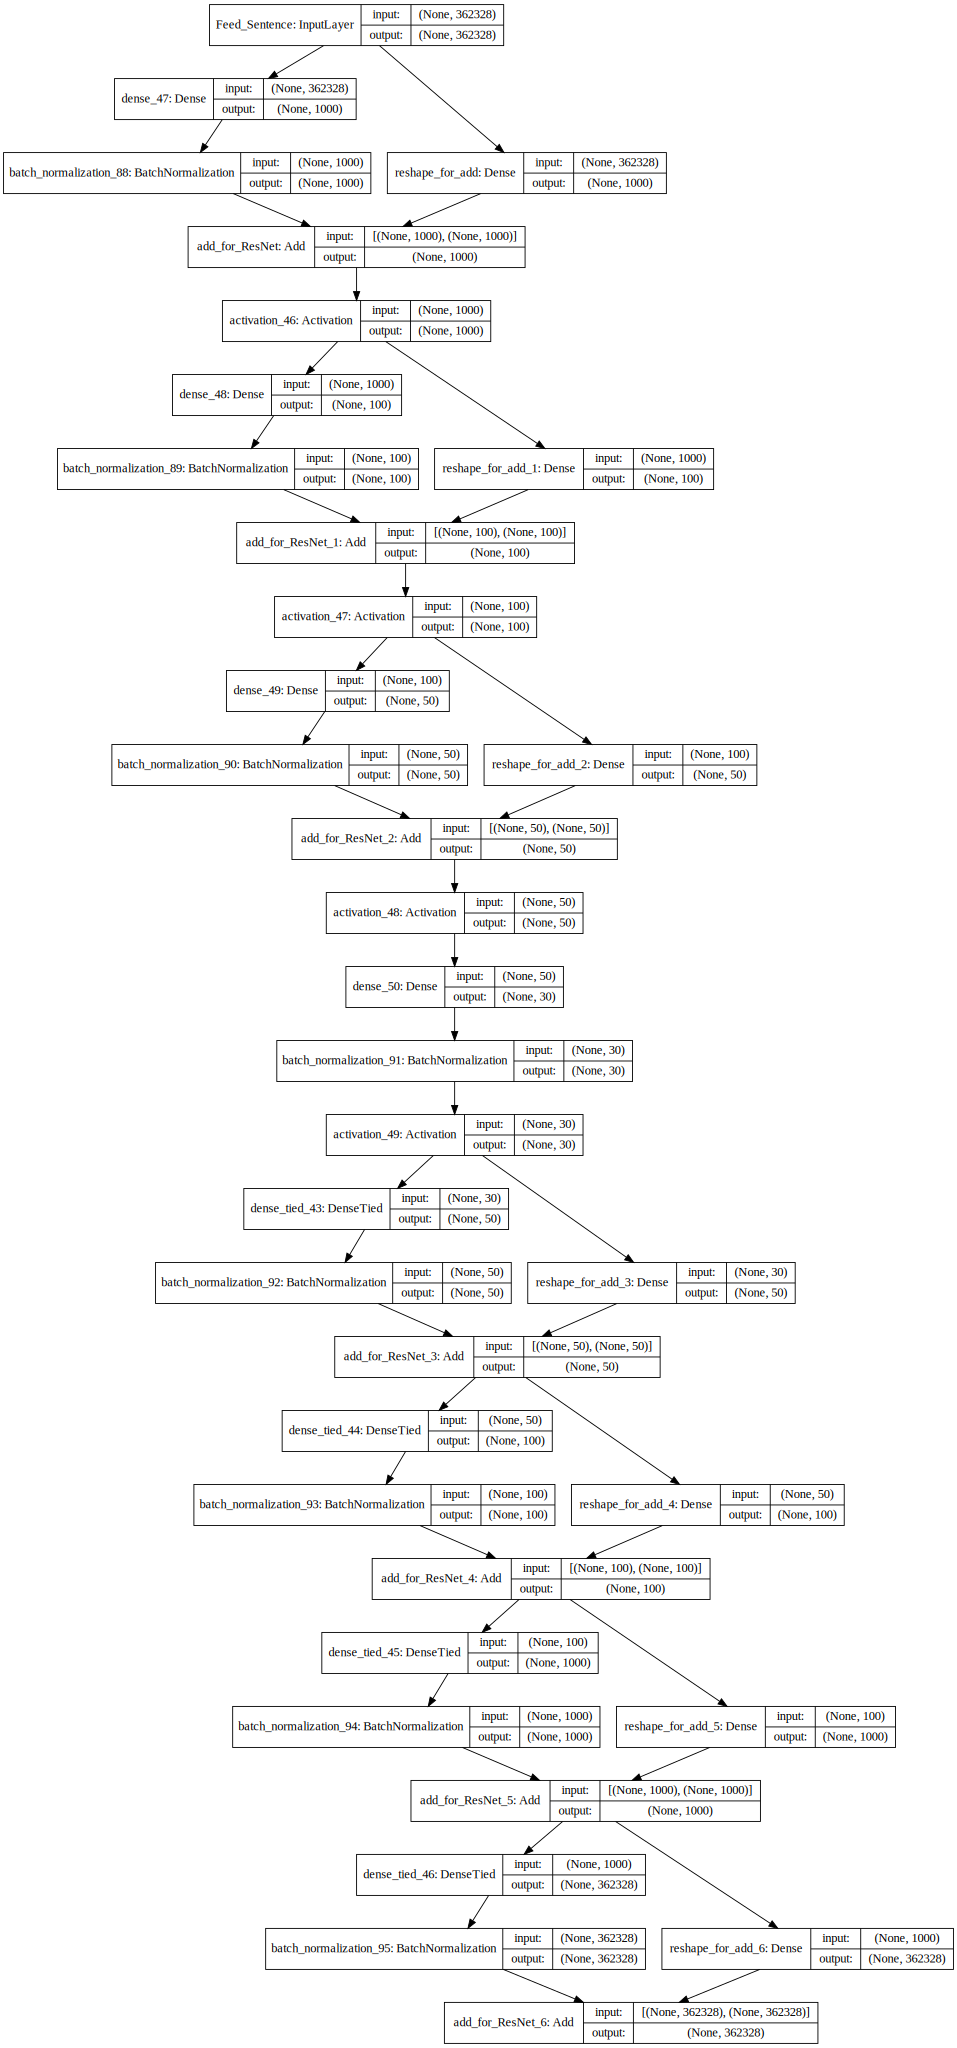

In [69]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(tag_identifier_2,show_shapes=True).create(prog="dot",format="svg"))

In [155]:
inputs_1_shape = X_train_songs.shape[1]

output_shape = y_train.shape[1]


inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(dictionary_songs) + 1 ,128)

embed_i = embed(inputs_1)
                
#encoder_dense = layers.Flatten()(embed_i)

#encoder_dense = layers.Lambda(lambda x: K.sum(x, axis=1),name="add_context_vectors_to_one")(embed_i)

Encoder1 = layers.GRU(128,input_shape=(None,128),name="Encoder3")
Encoder2 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder4")

initial_1 = Encoder1(embed_i)
initial_1 = layers.BatchNormalization(axis = 1)(initial_1)

initial_2 = Encoder2(embed_i)
initial_2 = layers.BatchNormalization(axis = 1)(initial_2)

encoder_dense = layers.Concatenate(axis = -1,name="song_initial_state_concat")([initial_1,initial_2])

#encoder_dense = layers.Add()([initial_1,initial_2])

output = layers.Dense(output_shape,activation="relu")(encoder_dense)

In [156]:
tag_identifier_songs = Model(inputs = [inputs_1], outputs = [output])

tag_identifier_songs.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 200, 128)     40462720    Feed_Sentence[0][0]              
__________________________________________________________________________________________________
Encoder3 (GRU)                  (None, 128)          98688       embedding_24[0][0]               
__________________________________________________________________________________________________
Encoder4 (GRU)                  (None, 128)          98688       embedding_24[0][0]               
__________________________________________________________________________________________________
batch_norm

In [157]:
tag_identifier_songs.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [154]:
    tag_identifier_songs.fit(X_train_songs
               ,y_train,
               epochs=20,
               batch_size = 16,
               validation_data = 
               (X_test_songs,
                y_test), 
               callbacks = [early_stopping])


Train on 142030 samples, validate on 60870 samples
Epoch 1/20
 28112/142030 [====>.........................] - ETA: 2:08:12 - loss: 43.7949 - acc: 0.0670

KeyboardInterrupt: 

In [162]:
inputs_1_shape = X_train_tags.shape[1]

output_shape = y_train.shape[1]


inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(dictionary_tags) + 1 ,128)

embed_i = embed(inputs_1)
                
#encoder_dense = layers.Flatten()(embed_i)

#encoder_dense = layers.Lambda(lambda x: K.sum(x, axis=1),name="add_context_vectors_to_one")(embed_i)

Encoder1 = layers.GRU(128,input_shape=(None,128),name="Encoder3")
Encoder2 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder4")

initial_1 = Encoder1(embed_i)
initial_1 = layers.BatchNormalization(axis = 1)(initial_1)

initial_2 = Encoder2(embed_i)
initial_2 = layers.BatchNormalization(axis = 1)(initial_2)

encoder_dense = layers.Concatenate(axis = -1,name="song_initial_state_concat")([initial_1,initial_2])

#encoder_dense = layers.Add()([initial_1,initial_2])

output = layers.Dense(output_shape,activation="relu")(encoder_dense)

In [163]:
tag_identifier_tag = Model(inputs = [inputs_1], outputs = [output])

tag_identifier_tag.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_Sentence (InputLayer)      (None, 6)            0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 6, 128)       3732736     Feed_Sentence[0][0]              
__________________________________________________________________________________________________
Encoder3 (GRU)                  (None, 128)          98688       embedding_26[0][0]               
__________________________________________________________________________________________________
Encoder4 (GRU)                  (None, 128)          98688       embedding_26[0][0]               
__________________________________________________________________________________________________
batch_norm

In [164]:
tag_identifier_tag.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [165]:
tag_identifier_tag.fit(X_train_tags
           ,y_train,
           epochs=20,
           batch_size = 16,
           validation_data = 
           (X_test_tags,
            y_test), 
           callbacks = [early_stopping])

Train on 142030 samples, validate on 60870 samples
Epoch 1/20
142030/142030 [==============================] - 1460s 10ms/step - loss: 34.7006 - acc: 0.2266 - val_loss: 30.3701 - val_acc: 0.2958
Epoch 2/20
142030/142030 [==============================] - 1459s 10ms/step - loss: 29.6333 - acc: 0.2691 - val_loss: 29.2098 - val_acc: 0.2791
Epoch 3/20
142030/142030 [==============================] - 1450s 10ms/step - loss: 28.1391 - acc: 0.2936 - val_loss: 28.3053 - val_acc: 0.3096
Epoch 4/20
142030/142030 [==============================] - 1447s 10ms/step - loss: 27.5992 - acc: 0.3020 - val_loss: 27.9366 - val_acc: 0.3023
Epoch 5/20
142030/142030 [==============================] - 1433s 10ms/step - loss: 27.1310 - acc: 0.3199 - val_loss: 27.4862 - val_acc: 0.3154
Epoch 6/20
142030/142030 [==============================] - 1415s 10ms/step - loss: 26.7992 - acc: 0.3199 - val_loss: 27.4121 - val_acc: 0.3120
Epoch 7/20
142030/142030 [==============================] - 1430s 10ms/step - loss: 2

C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


142030/142030 [==============================] - 1453s 10ms/step - loss: nan - acc: 7.0408e-06 - val_loss: nan - val_acc: 1.6428e-05
Epoch 10/20
 95696/142030 [===================>..........] - ETA: 7:28 - loss: nan - acc: 1.0450e-05

KeyboardInterrupt: 

In [167]:
inputs_1_shape = X_train_tags.shape[1]

output_shape = y_train.shape[1]


inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(dictionary_tags) + 1 ,128)

embed_i = embed(inputs_1)
                
encoder_dense = layers.Flatten()(embed_i)

encoder_dense = layers.BatchNormalization(axis = 1)(encoder_dense)


#encoder_dense = layers.Lambda(lambda x: K.sum(x, axis=1),name="add_context_vectors_to_one")(embed_i)

#Encoder1 = layers.GRU(128,input_shape=(None,128),name="Encoder3")
#Encoder2 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder4")

#initial_1 = Encoder1(embed_i)
#initial_1 = layers.BatchNormalization(axis = 1)(initial_1)

#initial_2 = Encoder2(embed_i)
#initial_2 = layers.BatchNormalization(axis = 1)(initial_2)

#encoder_dense = layers.Concatenate(axis = -1,name="song_initial_state_concat")([initial_1,initial_2])

#encoder_dense = layers.Add()([initial_1,initial_2])

output = layers.Dense(output_shape,activation="relu")(encoder_dense)

In [169]:
tag_identifier_tag = Model(inputs = [inputs_1], outputs = [output])

tag_identifier_tag.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feed_Sentence (InputLayer)   (None, 6)                 0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 6, 128)            3732736   
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 768)               3072      
_________________________________________________________________
dense_17 (Dense)             (None, 29160)             22424040  
Total params: 26,159,848
Trainable params: 26,158,312
Non-trainable params: 1,536
_________________________________________________________________


In [170]:
tag_identifier_tag.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [174]:

for i in range(0,20):
    tag_identifier_tag.fit(X_train_tags
               ,y_train,
               epochs=1,
               batch_size = 16,
               validation_data = 
               (X_test_tags,
                y_test), 
               callbacks = [early_stopping])
    tag_identifier_tag.save("model_tag_"+str(i)+".h5")




Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 2633s 19ms/step - loss: 29.3416 - acc: 0.3899 - val_loss: 29.9439 - val_acc: 0.3698
Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 2609s 18ms/step - loss: 28.5539 - acc: 0.3879 - val_loss: 29.4859 - val_acc: 0.3672
Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 2604s 18ms/step - loss: 28.0934 - acc: 0.3838 - val_loss: 29.6645 - val_acc: 0.3886
Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 2599s 18ms/step - loss: 27.6232 - acc: 0.3978 - val_loss: 29.1530 - val_acc: 0.4044
Train on 142030 samples, validate on 60870 samples
Epoch 1/1
142030/142030 [==============================] - 2602s 18ms/step - loss: 27.3168 - acc: 0.4100 - val_loss: 29.1765 - val_acc: 0.3894
Train on 142030 samples, valid

C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Train on 142030 samples, validate on 60870 samples
Epoch 1/1
 95968/142030 [===================>..........] - ETA: 13:29 - loss: 26.1535 - acc: 0.3919

KeyboardInterrupt: 

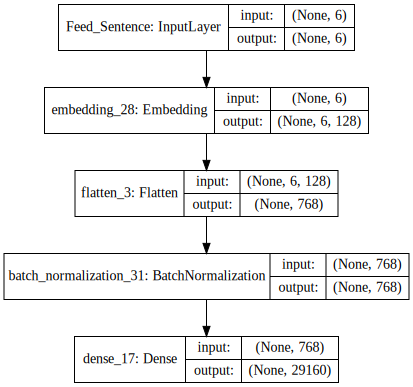

In [172]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(tag_identifier_tag,show_shapes=True).create(prog="dot",format="svg"))

In [187]:
inputs_1_shape = X_train_title.shape[1]
inputs_2_shape = X_train_songs.shape[1]
inputs_3_shape = X_train_tags.shape[1]

song_embedding_shape = len(dictionary_songs)
tag_embedding_shape = len(dictionary)

output_shape = tags_output.shape[1]
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(word2idx),128)

embed_i = embed(inputs_1)
            
cnns = layers.Conv1D(128,3,padding="valid",activation="relu",strides=1)(embed_i)
cnns = layers.BatchNormalization(axis = 1)(cnns)
cnns = layers.Dropout(0.2)(cnns)
cnns = layers.MaxPooling1D(pool_size = 4)(cnns)



#Bi-GRU 인코더 - 디코더 네트워크
Encoder1 = layers.GRU(128,return_sequences = True,return_state = True,input_shape=(None,128),name="Encoder1")
Encoder2 = layers.GRU(128,return_sequences = True,return_state = True,go_backwards = True,input_shape=(None,128),name="Encoder2")
attention_matrix1,initial_1 = Encoder1(cnns)
attention_matrix2,initial_2 = Encoder2(cnns)

attention_matrix = layers.Concatenate(axis=-1,name = "attention_matrix")([attention_matrix1,attention_matrix2])

attention_matrix = layers.BatchNormalization(axis = 1)(attention_matrix)


Decoder1 = layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder1")
Decoder2 =layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder2")
Decoder1_output = Decoder1(cnns,initial_state = initial_1)
Decoder2_output = Decoder2(cnns,initial_state = initial_2)

Decoder_output = layers.Concatenate(axis=-1,name="Decoder_output")([Decoder1_output,Decoder2_output])

Decoder_output = layers.BatchNormalization(axis = 1)(Decoder_output)

##어텐션 메커니즘 부분

#normalize = True로 켠 상태에서, dot product 유사도를 구할 수 있도록 둘을 내적한다.  
dot_product_similarity = layers.dot([Decoder_output,attention_matrix],axes = -1,normalize=True,name="dot_product_similarity")

#유사도 벡터를 softmax층에 통과시켜 총합이 1인 확률로 변환한다. 이를 attention_score로 명명한다.
attention_score_layer = layers.Softmax(axis=-1,name="attention_score_from_Softmax") 
attention_score = attention_score_layer(dot_product_similarity)

#Softmax 변환된 attention_score를 최초의 attention_matrix와 각각 내적한다.
context_vector = layers.Lambda(lambda x: K.tf.matmul(K.permute_dimensions(x[1],pattern=(0,2,1)),x[0]),
                                          name="weighted_and_making_context_vector")([attention_score,attention_matrix])
context_vector = layers.Permute((2,1))(context_vector)

# 하나로  합쳐서  가중치를  모든  Context Vector들이  공유하게  한다..
context_vector = layers.Lambda(lambda x: K.sum(x, axis=1),name="add_context_vectors_to_one")(context_vector)



inputs_2 = layers.Input(shape = [inputs_2_shape],name = "songs_input")

#곡에 대한 임베딩  레이어를 설정한다.

embed_2 = layers.Embedding(input_dim = song_embedding_shape + 1 , output_dim = 128, mask_zero = True)

embed_song = embed_2(inputs_2)

#임베딩 조회를 마치고 나온 임베딩 벡터들의 관계를 학습한다.

#song_dense = layers.Dense(256,activation = "relu")(embed_song)
embed_song = layers.Dropout(0.2)(embed_song)

embed_song = layers.BatchNormalization(axis = 1)(embed_song)

Encoder3 = layers.GRU(128,input_shape=(None,128),name="Encoder3")
Encoder4 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder4")

initial_3 = Encoder3(embed_song)
initial_4 = Encoder4(embed_song)

song_initial_concat = layers.Concatenate(axis = -1,name="song_initial_state_concat")([initial_3,initial_4])

song_dense = layers.BatchNormalization(axis = 1)(song_initial_concat)


inputs_3 = layers.Input(shape = [inputs_3_shape],name = "tags_input")

# 태그에 대한 임베딩 레이어를 설정한다.

embed_3 = layers.Embedding(tag_embedding_shape+1,128,mask_zero=True)

embed_tag = embed_3(inputs_3)

#임베딩 조회를 마치고 나온 임베딩 벡터들의 관계를 학습한다.

#tag_dense = layers.Dense(256,activation = "relu")(embed_tag)
embed_tag = layers.Dropout(0.2)(embed_tag)

embed_tag = layers.BatchNormalization(axis = 1)(embed_tag)

Encoder5 = layers.GRU(128,input_shape=(None,128),name="Encoder5")
Encoder6 = layers.GRU(128,go_backwards = True,input_shape=(None,128),name="Encoder6")

initial_5 = Encoder5(embed_tag)
initial_6 = Encoder6(embed_tag)

tag_initial_concat = layers.Concatenate(axis = -1,name="tag_initial_state_concat")([initial_5,initial_6])

tag_dense = layers.BatchNormalization(axis = 1)(tag_initial_concat)



# 두 벡터를  concat 하는  방안과,, add 하는  방안  두개를  모두  검토하자..
## concat : 두  Input Vector의  가중치가  분리된다..
## add : 두  Input Vector가  동일한  가중치를  공유한다..

concat_vector = layers.Concatenate(axis = -1, name = "concate_three_vector")([context_vector,
                                                                              song_dense,
                                                                                tag_dense
                                                                             ])

predicts = layers.Dense(output_shape,activation="relu")(concat_vector)

In [ ]:
tag_identifier_2.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [218]:
tag_identifier_2.fit([X_train_title,X_train_songs,X_train_tags]
           ,y_train,
           epochs=20,
           batch_size = 64,
           validation_data = 
           ([X_test_title,X_test_songs,X_test_tags],
            y_test),
           callbacks = [early_stopping])

Train on 142030 samples, validate on 60870 samples
Epoch 1/20
 11456/142030 [=>............................] - ETA: 1:59:34 - loss: 42.8366 - acc: 0.1501

KeyboardInterrupt: 

## 해야할 일들

### 1) like_cnt와 tag의 워드 임베딩간  동질성은 상관관계가 있다.
### 2) like_cnt를 하이퍼 파라미터로 사용하는 그리드 서치의 작성
### 3) tag_input(INPUT_3)을 기존의 매니-핫-인코딩이  아닌 워드  임베딩상의  중심점을 활용
#### (1) tag가 10개 있다고 칠 때, 10 개의  Vector를 모두  더해서  n으로 나눈다.

### 4) 태그 예측시
#### (1) 태그 절반 + 노래 이름
#### (2) 오직 노래 이름
#### (3) 일단은  (2)부터 진행

### 5) 노래 예측시
#### (1) 노래 절반 + 태그
#### (2) 오직  태그만
#### (3) 일단은  (2)부터 진행

## 원본 코드

In [ ]:
inputs_1_shape = None
inputs_2_shape = 20202
vocabulary = np.array([i for i in range(0,1000)])
tag_num = 29610
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs_1 = layers.Input(shape=[inputs_1_shape],name = "Feed_Sentence")

embed = layers.Embedding(len(vocabulary)+1,128)

embed_i = embed(inputs_1)
            
cnns = layers.Conv1D(256,3,padding="valid",activation="relu",strides=1)(embed_i)
cnns = layers.Dropout(0.2)(cnns)
cnns = layers.MaxPooling1D(pool_size = 4)(cnns)


#Bi-GRU 인코더 - 디코더 네트워크
Encoder1 = layers.GRU(128,return_sequences = True,return_state = True,input_shape=(None,128),name="Encoder1")
Encoder2 = layers.GRU(128,return_sequences = True,return_state = True,go_backwards = True,input_shape=(None,128),name="Encoder2")
attention_matrix1,initial_1 = Encoder1(cnns)
attention_matrix2,initial_2 = Encoder2(cnns)
attention_matrix = layers.Concatenate(axis=-1,name = "attention_matrix")([attention_matrix1,attention_matrix2])


Decoder1 = layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder1")
Decoder2 =layers.GRU(128,return_sequences = True,input_shape=(None,128),name="Decoder2")
Decoder1_output = Decoder1(cnns,initial_state = initial_1)
Decoder2_output = Decoder2(cnns,initial_state = initial_2)

Decoder_output = layers.Concatenate(axis=-1,name="Decoder_output")([Decoder1_output,Decoder2_output])


##어텐션 메커니즘 부분

#normalize = True로 켠 상태에서, dot product 유사도를 구할 수 있도록 둘을 내적한다.  
dot_product_similarity = layers.dot([Decoder_output,attention_matrix],axes = -1,normalize=True,name="dot_product_similarity")

#유사도 벡터를 softmax층에 통과시켜 총합이 1인 확률로 변환한다. 이를 attention_score로 명명한다.
attention_score_layer = layers.Softmax(axis=-1,name="attention_score_from_Softmax") 
attention_score = attention_score_layer(dot_product_similarity)

#Softmax 변환된 attention_score를 최초의 attention_matrix와 각각 내적한다.
context_vector = layers.Lambda(lambda x: K.tf.matmul(K.permute_dimensions(x[1],pattern=(0,2,1)),x[0]),
                                          name="weighted_and_making_context_vector")([attention_score,attention_matrix])
context_vector = layers.Permute((2,1))(context_vector)

#_,context_vector = layers.GRU(64,return_state = True,name="Hierarchical_GRU")(weighted_attention_matrix)

#concat = layers.Concatenate(axis=-1,name = "Concatenate_Decoder_O_and_Context_Vector")([Decoder_output,weighted_attention_matrix])

# 하나로  합쳐서  가중치를  모든  Context Vector들이  공유하게  한다..
context_vector = layers.Lambda(lambda x: K.sum(x, axis=1),name="add_context_vectors_to_one")(context_vector)

#Feed_forward = layers.Dense(512,activation = "tanh",name="Feed_forward")
#finally_output = Feed_forward(context_vector)

inputs_2 = layers.Input([inputs_2_shape])
song_dense = layers.Dense(256,activation = "relu")(inputs_2)
song_dense = layers.Dropout(0.2)(song_dense)
#song_dense_2 = layers.Dense(32, activation = "relu")(song_dense)

# 두 벡터를  concat 하는  방안과,, add 하는  방안  두개를  모두  검토하자..
## concat : 두  Input Vector의  가중치가  분리된다..
## add : 두  Input Vector가  동일한  가중치를  공유한다..
concat_two_vector = layers.Concatenate(axis = -1, name = "concate_two_vector")([context_vector,song_dense])

#다중 라벨 분류를 위해선 각 정답 노드들의 활성화 함수를 sigmoid로 잡는다. 

predicts = layers.Dense(tag_num,activation="sigmoid")(concat_two_vector)

GRUs_2 = Model(inputs = [inputs_1,inputs_2], outputs = [predicts])
GRUs_2.summary()